# tfp-multiple-changepoint-detection

Author: Henry Cooksley

Adapted from [Multiple changepoint detection and Bayesian model selection](https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection)

In [1]:
# Install requirements as needed
# !pip install -r requirements.txt

### Imports

In [2]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

### Task: changepoint detection with multiple changepoints

In [3]:
# true_rates = [40, 3, 20, 50]
# true_durations = [10, 20, 5, 35]
true_rates = [50, 3, 20, 50]
true_durations = [35, 20, 5, 35]
observed_counts = np.concatenate([
    scipy.stats.poisson(rate).rvs(num_steps) 
        for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)
observed_counts

array([43., 43., 50., 55., 56., 53., 41., 54., 59., 47., 44., 44., 41.,
       52., 65., 50., 55., 52., 50., 50., 43., 51., 59., 38., 48., 49.,
       64., 41., 44., 52., 51., 42., 49., 49., 59.,  7.,  1.,  3.,  1.,
        3.,  2.,  5.,  2.,  3.,  4.,  4.,  2.,  4.,  4.,  4.,  0.,  5.,
        3.,  2.,  5., 19., 19., 16., 18., 18., 41., 43., 56., 55., 53.,
       57., 42., 54., 33., 51., 51., 50., 42., 43., 48., 46., 43., 69.,
       66., 50., 50., 39., 40., 54., 55., 62., 45., 43., 55., 38., 55.,
       49., 34., 45., 52.], dtype=float32)

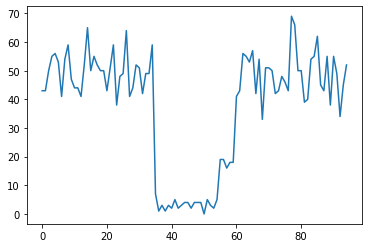

In [4]:
plt.plot(observed_counts);

### Known number of states

In [5]:
num_states = 4
# num_states = 2
initial_state_logits = np.zeros([num_states], dtype=np.float32)
initial_state_logits

array([0., 0., 0., 0.], dtype=float32)

In [6]:
daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
transition_probs

array([[0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667]], dtype=float32)

In [7]:
np.fill_diagonal(transition_probs, 
                 1-daily_change_prob)

In [8]:
print(f"Initial state logits:\n{initial_state_logits}")
print(f"Transition matrix:\n{transition_probs}")

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


In [9]:
trainable_log_rates = tf.Variable(
    np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
    name='log_rates')
trainable_log_rates

<tf.Variable 'log_rates:0' shape=(4,) dtype=float32, numpy=array([3.310855 , 3.4859166, 2.927331 , 4.0288177], dtype=float32)>

In [10]:
hmm = tfd.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(
        logits=initial_state_logits),
    transition_distribution=tfd.Categorical(probs=transition_probs),
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(observed_counts))
hmm

<tfp.distributions.HiddenMarkovModel 'HiddenMarkovModel' batch_shape=[] event_shape=[95] dtype=float32>

In [11]:
rate_prior = tfd.LogNormal(5, 5)
rate_prior

<tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>

In [12]:
def log_prob():
    return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
           hmm.log_prob(observed_counts))

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
optimizer

In [14]:
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)


In [15]:
for step in range(201):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 20 == 0:
        print(f"step {step}: log prob {-loss} rates {rates}")
        print("\n")

print("\n")
print(f"Inferred rates: {rates}")
print("\n")
print(f"True rates: {true_rates}")

step 0: log prob -555.094482421875 rates [24.800304 36.08642  16.900295 50.84683 ]
step 20: log prob -331.63330078125 rates [18.144554  59.377804   3.6147506 49.435432 ]
step 40: log prob -331.8392639160156 rates [17.656977  56.376183   2.5430295 48.843174 ]
step 60: log prob -328.12152099609375 rates [17.750824  48.617004   2.9529402 49.090244 ]
step 80: log prob -327.9198303222656 rates [17.819908  49.53541    3.2324002 49.291603 ]
step 100: log prob -327.90234375 rates [17.816076  49.114464   3.1770923 49.285374 ]
step 120: log prob -327.89068603515625 rates [17.80448   49.219017   3.1446407 49.28857  ]
step 140: log prob -327.8901062011719 rates [17.808996  49.26445    3.1578119 49.278687 ]
step 160: log prob -327.8901062011719 rates [17.808342 49.28422   3.158531 49.288593]
step 180: log prob -327.8897399902344 rates [17.807947  49.289944   3.1566663 49.28795  ]
step 200: log prob -327.8897705078125 rates [17.808054 49.28609   3.157269 49.28691 ]


Inferred rates: [17.808054 49.28

#### Recovering the state trajectory

In [16]:
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_dists

<tfp.distributions.Categorical 'HiddenMarkovModel_posterior_marginals_Categorical' batch_shape=[95] event_shape=[] dtype=int32>

In [17]:
posterior_probs = posterior_dists.probs_parameter().numpy()
posterior_probs

array([[7.88322794e-08, 4.99916017e-01, 8.98147295e-34, 5.00083864e-01],
       [2.71869061e-09, 4.99923706e-01, 3.09706486e-35, 5.00076294e-01],
       [2.18535129e-12, 4.99923706e-01, 0.00000000e+00, 5.00076294e-01],
       [1.34576900e-14, 4.99916077e-01, 0.00000000e+00, 5.00083923e-01],
       [4.86253832e-15, 4.99923706e-01, 0.00000000e+00, 5.00076294e-01],
       [1.03085780e-13, 4.99916077e-01, 0.00000000e+00, 5.00083923e-01],
       [2.08226005e-08, 4.99923706e-01, 7.54711013e-33, 5.00076294e-01],
       [3.72475657e-14, 4.99916077e-01, 0.00000000e+00, 5.00083923e-01],
       [2.29358099e-16, 4.99916077e-01, 0.00000000e+00, 5.00083923e-01],
       [4.63308419e-11, 4.99916077e-01, 0.00000000e+00, 5.00083923e-01],
       [9.82183557e-10, 4.99923706e-01, 1.98393962e-36, 5.00076294e-01],
       [9.82228521e-10, 4.99916077e-01, 1.98396993e-36, 5.00083923e-01],
       [2.08226005e-08, 4.99923706e-01, 7.54711013e-33, 5.00076294e-01],
       [2.85298586e-13, 4.99916077e-01, 0.00000000e

In [18]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
    ax2.set_title(title)
    ax2.set_xlabel('time')
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)


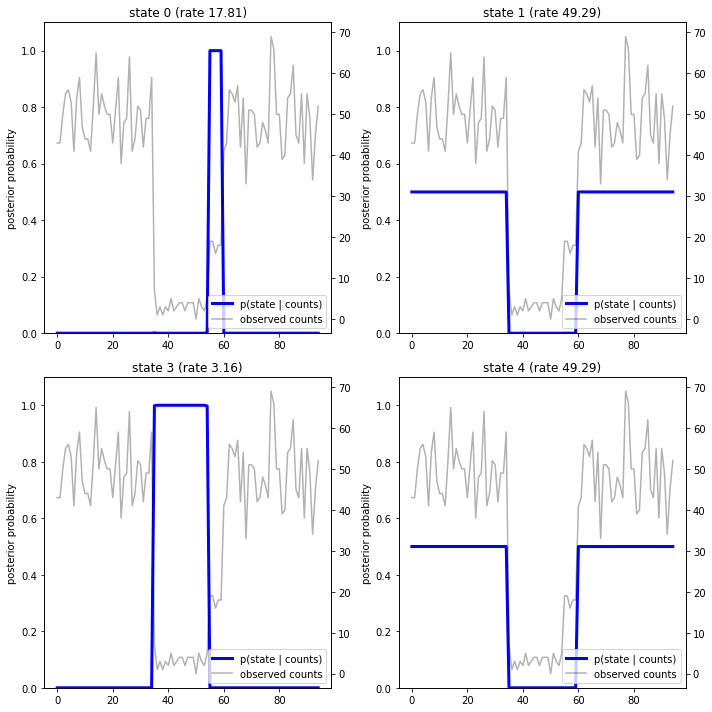

In [19]:
fig = plt.figure(figsize=(10, 10))
nrows_ncols = (2, 2)
plot_state_posterior(fig.add_subplot(*nrows_ncols, 1),
                    posterior_probs[:, 0],
                    title=f"state 0 (rate {rates[0]:.2f})")
plot_state_posterior(fig.add_subplot(*nrows_ncols, 2),
                    posterior_probs[:, 1],
                    title=f"state 1 (rate {rates[1]:.2f})")
if num_states == 4:
    plot_state_posterior(fig.add_subplot(*nrows_ncols, 3),
                        posterior_probs[:, 2],
                        title=f"state 3 (rate {rates[2]:.2f})")
    plot_state_posterior(fig.add_subplot(*nrows_ncols, 4),
                        posterior_probs[:, 3],
                        title=f"state 4 (rate {rates[3]:.2f})")
plt.tight_layout()

In [20]:
most_probable_states = np.argmax(posterior_probs, axis=1)
most_probable_states

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [21]:
most_probable_rates = rates[most_probable_states]
most_probable_rates

array([49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 ,
       49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 ,
       49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 ,
       49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 ,
       49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 ,
       49.28691 , 49.28691 , 49.28691 , 49.28691 , 49.28691 ,  3.157269,
        3.157269,  3.157269,  3.157269,  3.157269,  3.157269,  3.157269,
        3.157269,  3.157269,  3.157269,  3.157269,  3.157269,  3.157269,
        3.157269,  3.157269,  3.157269,  3.157269,  3.157269,  3.157269,
        3.157269, 17.808054, 17.808054, 17.808054, 17.808054, 17.808054,
       49.28609 , 49.28609 , 49.28609 , 49.28609 , 49.28609 , 49.28609 ,
       49.28609 , 49.28609 , 49.28609 , 49.28609 , 49.28609 , 49.28609 ,
       49.28609 , 49.28609 , 49.28609 , 49.28609 , 49.28609 , 49.28609 ,
       49.28609 , 49.28609 , 49.28609 , 49.28609 , 

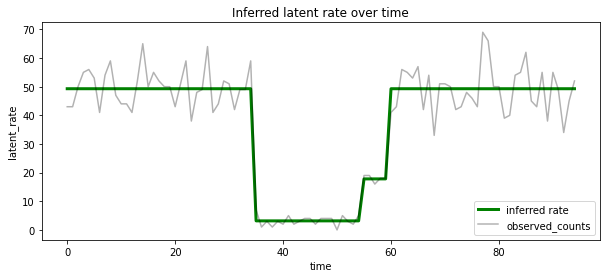

In [22]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed_counts')
ax.set_ylabel('latent_rate')
ax.set_xlabel('time')
ax.set_title('Inferred latent rate over time')
ax.legend(loc=4);

### Unknown number of states

In [23]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):
    
    # Give probability exp(-100) ~= 0 to states outside of the current model.
    initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
    initial_state_logits[:num_states] = 0.
    
    # Build a transition matrix that transitions only within the current `num_states` states.
    transition_probs = np.eye(max_num_states, dtype=np.float32)
    if num_states > 1:
        transition_probs[:num_states, :num_states] = (
            daily_change_prob / (num_states-1))
        np.fill_diagonal(transition_probs[:num_states, :num_states],
                        1-daily_change_prob)
    return initial_state_logits, transition_probs    

In [24]:
# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
    initial_state_logits, transition_probs = build_latent_state(
        num_states=num_states,
        max_num_states=max_num_states)
    batch_initial_state_logits.append(initial_state_logits)
    batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_initial_state_logits

array([[   0., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100.],
       [   0.,    0., -100., -100., -100., -100., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0., -100., -100., -100., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0., -100., -100., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0., -100., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]], dtype=float32)

In [25]:
batch_transition_probs = np.array(batch_transition_probs)
batch_transition_probs

array([[[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [26]:
print(f"Shape of initial_state_logits: {batch_initial_state_logits.shape}")

Shape of initial_state_logits: (10, 10)


In [27]:
print(f"Shape of transition probs: {batch_transition_probs.shape}")

Shape of transition probs: (10, 10, 10)


In [28]:
print(f"Example initial state logits for num_states==3:\n{batch_initial_state_logits[2, :]}")


Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100. -100. -100. -100. -100.]


In [29]:
print(f"Example transition_probs for num_states==3:\n{batch_transition_probs[2, :, :]}")

Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [30]:
trainable_log_rates = tf.Variable(
    (np.log(np.mean(observed_counts)) *
    np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
    tf.random.normal([1, max_num_states])),
    name='log_rates')
trainable_log_rates

<tf.Variable 'log_rates:0' shape=(10, 10) dtype=float32, numpy=
array([[4.1059833, 1.7695768, 4.0076337, 3.6975305, 2.1907833, 4.1137943,
        3.9279902, 3.4425225, 3.3284113, 3.1024466],
       [4.1059833, 1.7695768, 4.0076337, 3.6975305, 2.1907833, 4.1137943,
        3.9279902, 3.4425225, 3.3284113, 3.1024466],
       [4.1059833, 1.7695768, 4.0076337, 3.6975305, 2.1907833, 4.1137943,
        3.9279902, 3.4425225, 3.3284113, 3.1024466],
       [4.1059833, 1.7695768, 4.0076337, 3.6975305, 2.1907833, 4.1137943,
        3.9279902, 3.4425225, 3.3284113, 3.1024466],
       [4.1059833, 1.7695768, 4.0076337, 3.6975305, 2.1907833, 4.1137943,
        3.9279902, 3.4425225, 3.3284113, 3.1024466],
       [4.1059833, 1.7695768, 4.0076337, 3.6975305, 2.1907833, 4.1137943,
        3.9279902, 3.4425225, 3.3284113, 3.1024466],
       [4.1059833, 1.7695768, 4.0076337, 3.6975305, 2.1907833, 4.1137943,
        3.9279902, 3.4425225, 3.3284113, 3.1024466],
       [4.1059833, 1.7695768, 4.0076337, 3.6975

In [32]:
hmm = tfd.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(
        logits=batch_initial_state_logits),
    transition_distribution=tfd.Categorical(probs=batch_transition_probs),
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(observed_counts))
hmm

<tfp.distributions.HiddenMarkovModel 'HiddenMarkovModel' batch_shape=[10] event_shape=[95] dtype=float32>

In [33]:
rate_prior = tfd.LogNormal(5, 5)
rate_prior

<tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>

In [34]:
def log_prob():
    prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
    prior_lp = tf.stack(
        [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
    return prior_lp + hmm.log_prob(observed_counts)

In [35]:
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)

In [38]:
for step in range(201):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 20 == 0:
        print(f"step {step}:")
        print(f"loss {loss}")
        print("\n")

step 0:
loss [974.0143  366.72928 322.50348 328.7373  334.01688 336.7311  344.03543
 348.16037 348.7186  345.17026]


step 20:
loss [974.0144  366.7294  322.50348 328.7372  334.0167  336.73126 344.0354
 348.1604  348.5397  344.8666 ]


step 40:
loss [974.01355 366.7294  322.50348 328.7372  334.01685 336.73135 344.03546
 348.1604  348.36725 344.58582]


step 60:
loss [974.0143  366.72934 322.50348 328.7372  334.0168  336.7312  344.0355
 348.16043 348.20193 344.32626]


step 80:
loss [974.01355 366.7294  322.50348 328.7372  334.01685 336.73117 344.03543
 348.16016 348.043   344.08652]


step 100:
loss [974.0144  366.72955 322.50348 328.7373  334.01688 336.7311  344.03555
 348.1605  347.89096 343.86465]


step 120:
loss [974.0143  366.7294  322.50348 328.7373  334.01666 336.7313  344.03543
 348.16046 347.7454  343.6593 ]


step 140:
loss [974.0143  366.72955 322.50366 328.7373  334.0168  336.731   344.0354
 348.16046 347.60663 343.46957]


step 160:
loss [974.0144  366.7294  322.50366 328

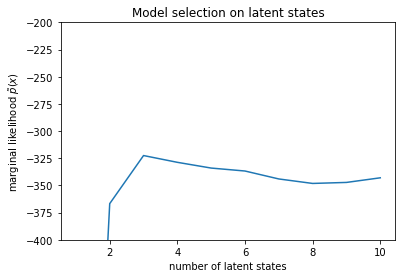

In [40]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -loss)
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states");